# SpatialIQ: Predicting Students' Spatial Intelligence through Machine Learning

## A Comprehensive AI-in-Education Research Study

**Author:** AI Research Developer Daniel Wanjala Machimbo  
**Date:** November 2025  
**Dataset Citation:** DOI: 10.21227/5qxw-bw66  
**Purpose:** Interpretable prediction and analysis of spatial intelligence in high school students using behavioral, academic, and demographic features

---

## Executive Summary

This notebook presents a rigorous machine learning pipeline designed to predict students' **Spatial Intelligence** levels (ranging from Very Low to Very High) using a rich dataset of 40 behavioral, academic, and demographic features collected from high school students. Spatial intelligence—the ability to visualize, manipulate, and reason about spatial relationships—is a critical component of cognitive development and academic achievement, particularly in STEM disciplines.

### Research Questions:
1. **What behavioral and academic patterns predict spatial intelligence?**
2. **How do demographic factors (gender, parental education, environment) influence spatial reasoning ability?**
3. **Can we build interpretable models that identify actionable insights for educators?**
4. **What ethical considerations arise from AI-driven student cognitive profiling?**

### Methodology Overview:
- **Phase 1:** Comprehensive data exploration and statistical profiling
- **Phase 2:** Intelligent feature engineering with domain knowledge
- **Phase 3:** Competitive modeling with Logistic Regression, Random Forest, XGBoost, and Neural Networks
- **Phase 4:** Deep model interpretation using SHAP explainability methods
- **Phase 5:** Actionable insights and ethical considerations

---

## Dataset Overview

The dataset comprises 398 high school students with 40 features across five categories:
- **Demographics:** Age, Gender, Class size, Environment (Urban/Suburban/Rural)
- **Socioeconomic:** Family size, Parental occupation, Parental education, Income level
- **Academic:** Major, GPA, Study time, Extra classes, Teacher assessment
- **Behavioral:** Internet usage, TV watching, Pattern recognition, Geographic familiarity
- **Gaming Preferences:** Action, Adventure, Strategy, Sport, Simulation, Role-playing, Puzzle games
- **Learning Modes:** Visual vs. Auditory, Map usage, Diagram usage, Experience with GIS

**Target Variable:** Spatial Intelligence (Categorical: VL, L, M, H, VH)


---

# Section 1: Import Required Libraries and Dataset Loading

This foundational section initializes all necessary libraries for data manipulation, visualization, machine learning, and model interpretation. We leverage industry-standard tools including pandas for data handling, scikit-learn for preprocessing and modeling, XGBoost for gradient boosting, TensorFlow for neural networks, and SHAP for model explainability. This comprehensive toolkit enables both rigorous statistical analysis and production-grade machine learning workflows.

In [11]:
# ==================== IMPORT LIBRARIES ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             matthews_corrcoef)
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
import xgboost as xgb

# SHAP for model interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️  SHAP library not available. Install with: pip install shap")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization defaults for publication-quality charts
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 13

print("=" * 80)
print("LIBRARY IMPORT COMPLETE")
print("=" * 80)
print("\n✓ All required libraries imported successfully")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ Matplotlib version: {plt.matplotlib.__version__}")
print(f"✓ Seaborn version: {sns.__version__}")
print(f"✓ Scikit-learn available")
print(f"✓ XGBoost available")
print(f"✓ SHAP available: {SHAP_AVAILABLE}")

# ==================== SMART VISUALIZATION UTILITIES ====================
print("\n" + "=" * 80)
print("SMART VISUALIZATION UTILITY FUNCTIONS")
print("=" * 80)

def smart_plot_distribution(data, column, ax=None, plot_type='auto', top_n=20, 
                            figsize=(10, 6), title=None, rotation='auto'):
    """
    Automatically detect and plot distribution with optimal formatting.
    
    Parameters:
    -----------
    data : DataFrame
        Input data
    column : str
        Column name to plot
    ax : matplotlib axis, optional
        Axis to plot on
    plot_type : str
        'auto', 'categorical', 'continuous', 'bar', 'hist', 'kde', 'pie'
    top_n : int
        Maximum categories to show for categorical data
    figsize : tuple
        Figure size if creating new figure
    title : str
        Plot title
    rotation : str or int
        'auto' for smart rotation, or specific angle
    """
    
    # Auto-detect column type
    n_unique = data[column].nunique()
    
    if plot_type == 'auto':
        if n_unique < 20:
            plot_type = 'categorical'
        else:
            plot_type = 'continuous'
    
    # Create axis if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Handle categorical data
    if plot_type in ['categorical', 'bar', 'pie']:
        value_counts = data[column].value_counts()
        
        # Limit to top N if too many categories
        if len(value_counts) > top_n:
            value_counts = value_counts.nlargest(top_n)
            title_suffix = f" (Top {top_n})"
        else:
            title_suffix = ""
        
        if plot_type == 'pie':
            colors = sns.color_palette("Spectral", len(value_counts))
            wedges, texts, autotexts = ax.pie(
                value_counts.values,
                labels=None,
                autopct='%1.1f%%',
                colors=colors,
                startangle=90,
                pctdistance=0.85
            )
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
            ax.legend(wedges, value_counts.index, loc="best", fontsize=9)
        else:
            # Bar plot
            colors = sns.color_palette("husl", len(value_counts))
            bars = ax.bar(range(len(value_counts)), value_counts.values, 
                         color=colors, edgecolor='black', linewidth=1, alpha=0.85)
            
            # Smart rotation
            if rotation == 'auto':
                max_label_len = max(len(str(lbl)) for lbl in value_counts.index)
                if max_label_len > 15:
                    rotation = 45
                    ha = 'right'
                elif max_label_len > 10:
                    rotation = 30
                    ha = 'right'
                else:
                    rotation = 0
                    ha = 'center'
            else:
                ha = 'right' if rotation > 0 else 'center'
            
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(value_counts.index, rotation=rotation, ha=ha, fontsize=9)
            ax.set_ylabel('Count', fontweight='bold')
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        if title:
            ax.set_title(title + title_suffix, fontweight='bold', pad=10)
        else:
            ax.set_title(f'Distribution of {column}{title_suffix}', fontweight='bold', pad=10)
    
    # Handle continuous data
    else:
        if plot_type == 'kde':
            sns.kdeplot(data=data, x=column, ax=ax, fill=True, alpha=0.6)
        else:
            ax.hist(data[column].dropna(), bins=30, edgecolor='black', 
                   color='steelblue', alpha=0.7)
        
        ax.set_xlabel(column, fontweight='bold')
        ax.set_ylabel('Density' if plot_type == 'kde' else 'Count', fontweight='bold')
        if title:
            ax.set_title(title, fontweight='bold', pad=10)
        else:
            ax.set_title(f'Distribution of {column}', fontweight='bold', pad=10)
    
    ax.grid(alpha=0.3, linestyle='--')
    return ax


def truncate_labels(labels, max_len=35):
    """Truncate long labels for better visualization."""
    return [str(lbl)[:max_len-3] + '...' if len(str(lbl)) > max_len else str(lbl) 
            for lbl in labels]


def smart_heatmap(data, figsize='auto', annot=True, fmt='.2f', cmap='RdBu_r', 
                 title=None, max_features=50):
    """
    Create a heatmap with smart sizing and formatting.
    
    Parameters:
    -----------
    data : DataFrame or array
        Correlation matrix or similar
    figsize : tuple or 'auto'
        Figure size
    annot : bool
        Show annotations
    fmt : str
        Annotation format
    cmap : str
        Color map
    title : str
        Plot title
    max_features : int
        Maximum features to show (truncate if more)
    """
    
    # Truncate if too many features
    if isinstance(data, pd.DataFrame) and len(data) > max_features:
        data = data.iloc[:max_features, :max_features]
        print(f"⚠️  Truncated to top {max_features} features for visualization")
    
    # Smart figure sizing
    if figsize == 'auto':
        n_features = len(data)
        size = max(10, min(20, n_features * 0.5))
        figsize = (size, size)
    
    # Determine annotation based on size
    if len(data) > 20:
        annot = False
        annot_fontsize = 6
    elif len(data) > 10:
        annot_fontsize = 7
    else:
        annot_fontsize = 9
    
    plt.figure(figsize=figsize)
    sns.heatmap(data, annot=annot, fmt=fmt, cmap=cmap, 
               center=0, linewidths=0.5,
               annot_kws={'fontsize': annot_fontsize},
               cbar_kws={'label': 'Correlation'})
    
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    
    if title:
        plt.title(title, fontweight='bold', fontsize=13, pad=12)
    
    plt.tight_layout()
    return plt.gcf()

print("\n✓ Smart visualization utilities loaded:")
print("   - smart_plot_distribution(): Auto-detect and plot distributions")
print("   - truncate_labels(): Handle long labels gracefully")
print("   - smart_heatmap(): Create readable correlation heatmaps")
print("\n✅ All utilities ready for use!")


⚠️  SHAP library not available. Install with: pip install shap
LIBRARY IMPORT COMPLETE

✓ All required libraries imported successfully
✓ NumPy version: 2.3.3
✓ Pandas version: 2.3.2
✓ Matplotlib version: 3.10.6
✓ Seaborn version: 0.13.2
✓ Scikit-learn available
✓ XGBoost available
✓ SHAP available: False

SMART VISUALIZATION UTILITY FUNCTIONS

✓ Smart visualization utilities loaded:
   - smart_plot_distribution(): Auto-detect and plot distributions
   - truncate_labels(): Handle long labels gracefully
   - smart_heatmap(): Create readable correlation heatmaps

✅ All utilities ready for use!


## 1.1: Load and Inspect the Dataset

In this subsection, we load the Dataset.csv file and perform initial exploratory inspection to understand the data structure, dimensions, data types, and preliminary statistical characteristics. This foundational step is critical for identifying potential data quality issues, missing values, and the nature of features we'll be working with throughout the analysis.

In [12]:
# Load the dataset from CSV file
data_path = Path("data/Dataset.csv")
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("=" * 80)
print("DATASET LOADING AND INITIAL INSPECTION")
print("=" * 80)
print(f"\n✓ Dataset successfully loaded from: {data_path}")
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display column names and data types
print("\n" + "=" * 80)
print("COLUMN INFORMATION AND DATA TYPES")
print("=" * 80)
print("\nColumn Names and Data Types:")
print(df.info())

# Display summary statistics
print("\n" + "=" * 80)
print("FIRST 10 ROWS OF DATA")
print("=" * 80)
display(df.head(10))

print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
display(df.describe().transpose())

# Check for missing values
print("\n" + "=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)
missing_counts = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\nColumns with missing values ({len(missing_df)} found):")
    display(missing_df)
else:
    print("\n✓ No missing values detected in the dataset!")

# Identify target variable
print("\n" + "=" * 80)
print("TARGET VARIABLE IDENTIFICATION")
print("=" * 80)
print("\nDataset column names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

# The last column is typically the target (Spatial Intelligence level)
target_col = df.columns[-1]
print(f"\n✓ Identified target variable: '{target_col}'")
print(f"Unique values in target: {df[target_col].unique()}")
print(f"Target value counts:\n{df[target_col].value_counts().sort_index()}")

# Create a reference dictionary for later use
target_mapping = {val: idx for idx, val in enumerate(sorted(df[target_col].unique()))}
print(f"\nTarget ordinal mapping: {target_mapping}")

DATASET LOADING AND INITIAL INSPECTION

✓ Dataset successfully loaded from: data\Dataset.csv

Dataset Shape: 396 rows × 1 columns
Memory Usage: 0.07 MB

COLUMN INFORMATION AND DATA TYPES

Column Names and Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                            

,AgeGenderClass sizeEnvironmentMajorFamily sizeFathers jobMothers jobFathers educationMothers educationparents incomeTravel-duralationSchool typeStudy timeExtra classWorkUsing InternetWatching TVPlaying games G-Action G-Adventure G-Strategy G-Sport G-Simulation G-Role-playing G-Puzzle G-NotMathScienceArtSportGPAUsing mapUsing diagram/chartTo learningUnfamiliar locationsGeography coursesExperience using GISFinding directionFind patterns & relationshipsCat2
0,18Female1UrbanTechnical1ServicesUnemplo...
1,15Female2UrbanVocational1ServicesAgricu...
2,16Male1UrbanHumanism0Agriculture and env...
3,15Female0SuburbanScience0ServicesServic...
4,16Female1UrbanTechnical1Agriculture and ...
5,18Female2UrbanHumanism2Education and soc...
6,14Female2UrbanScience0ServicesUnemploym...
7,15Male1UrbanVocational1Education and soc...
8,18Female1UrbanTechnical0HealthHealth2...
9,14Female1UrbanTechnical0ServicesUnemplo...



SUMMARY STATISTICS


,count,unique,top,freq
AgeGenderClass sizeEnvironmentMajorFamily sizeFathers jobMothers jobFathers educationMothers educationparents incomeTravel-duralationSchool typeStudy timeExtra classWorkUsing InternetWatching TVPlaying games G-Action G-Adventure G-Strategy G-Sport G-Simulation G-Role-playing G-Puzzle G-NotMathScienceArtSportGPAUsing mapUsing diagram/chartTo learningUnfamiliar locationsGeography coursesExperience using GISFinding directionFind patterns & relationshipsCat2,396,396,18Female1UrbanTechnical1ServicesUnemplo...,1



MISSING VALUES ANALYSIS

✓ No missing values detected in the dataset!

TARGET VARIABLE IDENTIFICATION

Dataset column names:
 1. AgeGenderClass sizeEnvironmentMajorFamily sizeFathers jobMothers jobFathers educationMothers educationparents incomeTravel-duralationSchool typeStudy timeExtra classWorkUsing InternetWatching TVPlaying games G-Action G-Adventure G-Strategy G-Sport G-Simulation G-Role-playing G-Puzzle G-NotMathScienceArtSportGPAUsing mapUsing diagram/chartTo learningUnfamiliar locationsGeography coursesExperience using GISFinding directionFind patterns & relationshipsCat2

✓ Identified target variable: 'AgeGenderClass sizeEnvironmentMajorFamily sizeFathers jobMothers jobFathers educationMothers educationparents incomeTravel-duralationSchool typeStudy timeExtra classWorkUsing InternetWatching TVPlaying games G-Action G-Adventure G-Strategy G-Sport G-Simulation G-Role-playing G-Puzzle G-NotMathScienceArtSport

---

# Section 2: Exploratory Data Analysis and Statistical Profiling

## 2.1: Distribution Analysis of Spatial Intelligence

Spatial Intelligence is our target variable, classified into five ordinal categories ranging from Very Low (VL) to Very High (VH). Understanding the distribution of this outcome variable is crucial for identifying potential class imbalance issues and informing our choice of evaluation metrics and sampling strategies. We'll visualize this distribution through multiple perspectives: raw counts, percentages, and normalized visualizations.

TARGET VARIABLE DISTRIBUTION ANALYSIS

Target Column: AgeGenderClass sizeEnvironmentMajorFamily sizeFathers jobMothers jobFathers educationMothers educationparents incomeTravel-duralationSchool typeStudy timeExtra classWorkUsing InternetWatching TVPlaying games G-Action G-Adventure G-Strategy G-Sport G-Simulation G-Role-playing G-Puzzle G-NotMathScienceArtSportGPAUsing mapUsing diagram/chartTo learningUnfamiliar locationsGeography coursesExperience using GISFinding directionFind patterns & relationshipsCat2
Unique Values: 396
Data Type: object

All Unique Values:
['18\x1bFemale\x1b1\x1bUrban\x1bTechnical\x1b1\x1bServices\x1bUnemployment\x1b3\x1b2\x1b1\x1b2\x1bPrivate\x1b0\x1bYes\x1bNo\x1b3\x1b2\x1b2\x1b0\x1b0\x1b0\x1b0\x1b1\x1b0\x1b1\x1b0\x1b3\x1b1\x1b3\x1b3\x1b16/99\x1b2\x1b4\x1bView\x1b1\x1b5\x1bNo\x1b2\x1b2\x1bA'
 '15\x1bFemale\x1b2\x1bUrban\x1bVocational\x1b1\x1bServices\x1bAgriculture and env\x1b1\x1b1\x1b2\x1b2\x1bPrivate\x1b2\x1bYes\x1bNo\

,Spatial_Intelligence_Level,Count,Percentage,Cumulative_Percentage
0,14Female0UrbanHumanism0ServicesServices...,1,0.252525,0.252525
1,14Female0UrbanNot chosen yet0ServicesSe...,1,0.252525,0.505051
2,14Female0UrbanScience0HealthHealth32...,1,0.252525,0.757576
3,14Female0UrbanScience1Education and soci...,1,0.252525,1.010101
4,14Female0UrbanScience2Education and soci...,1,0.252525,1.262626
...,...,...,...,...
391,19Male2UrbanNot chosen yet2ServicesHeal...,1,0.252525,98.989899
392,19Male2UrbanScience1EngineeringUnemploy...,1,0.252525,99.242424
393,19Male2UrbanScience2Education and social...,1,0.252525,99.494949
394,19Male2UrbanTechnical0EngineeringEducat...,1,0.252525,99.747475



Class Balance Weights (for handling imbalance):
  14Female0UrbanHumanism0ServicesServices3321Public2NoYes22000100001211417/2433Hear12No02C: 1.0000
  14Female0UrbanNot chosen yet0ServicesServices2313Private0YesYes20010010110022212/1212View15No02C: 1.0000
  14Female0UrbanScience0HealthHealth3222Public1NoNo30101001000114214/1501View02No20C: 1.0000
  14Female0UrbanScience1Education and socialHealth2231Private1NoNo30001100000021214/1220View26No00C: 1.0000
  14Female0UrbanScience2Education and socialUnemployment3201Public2NoNo0011000010104211821View13No01B: 1.0000
  14Female0UrbanTechnical2HealthEducation and social2122Public2NoNo11210101000222018/6410Hear05No01B: 1.0000
  14Female0UrbanTechnical2HealthEducation and social2122Public2NoNo1

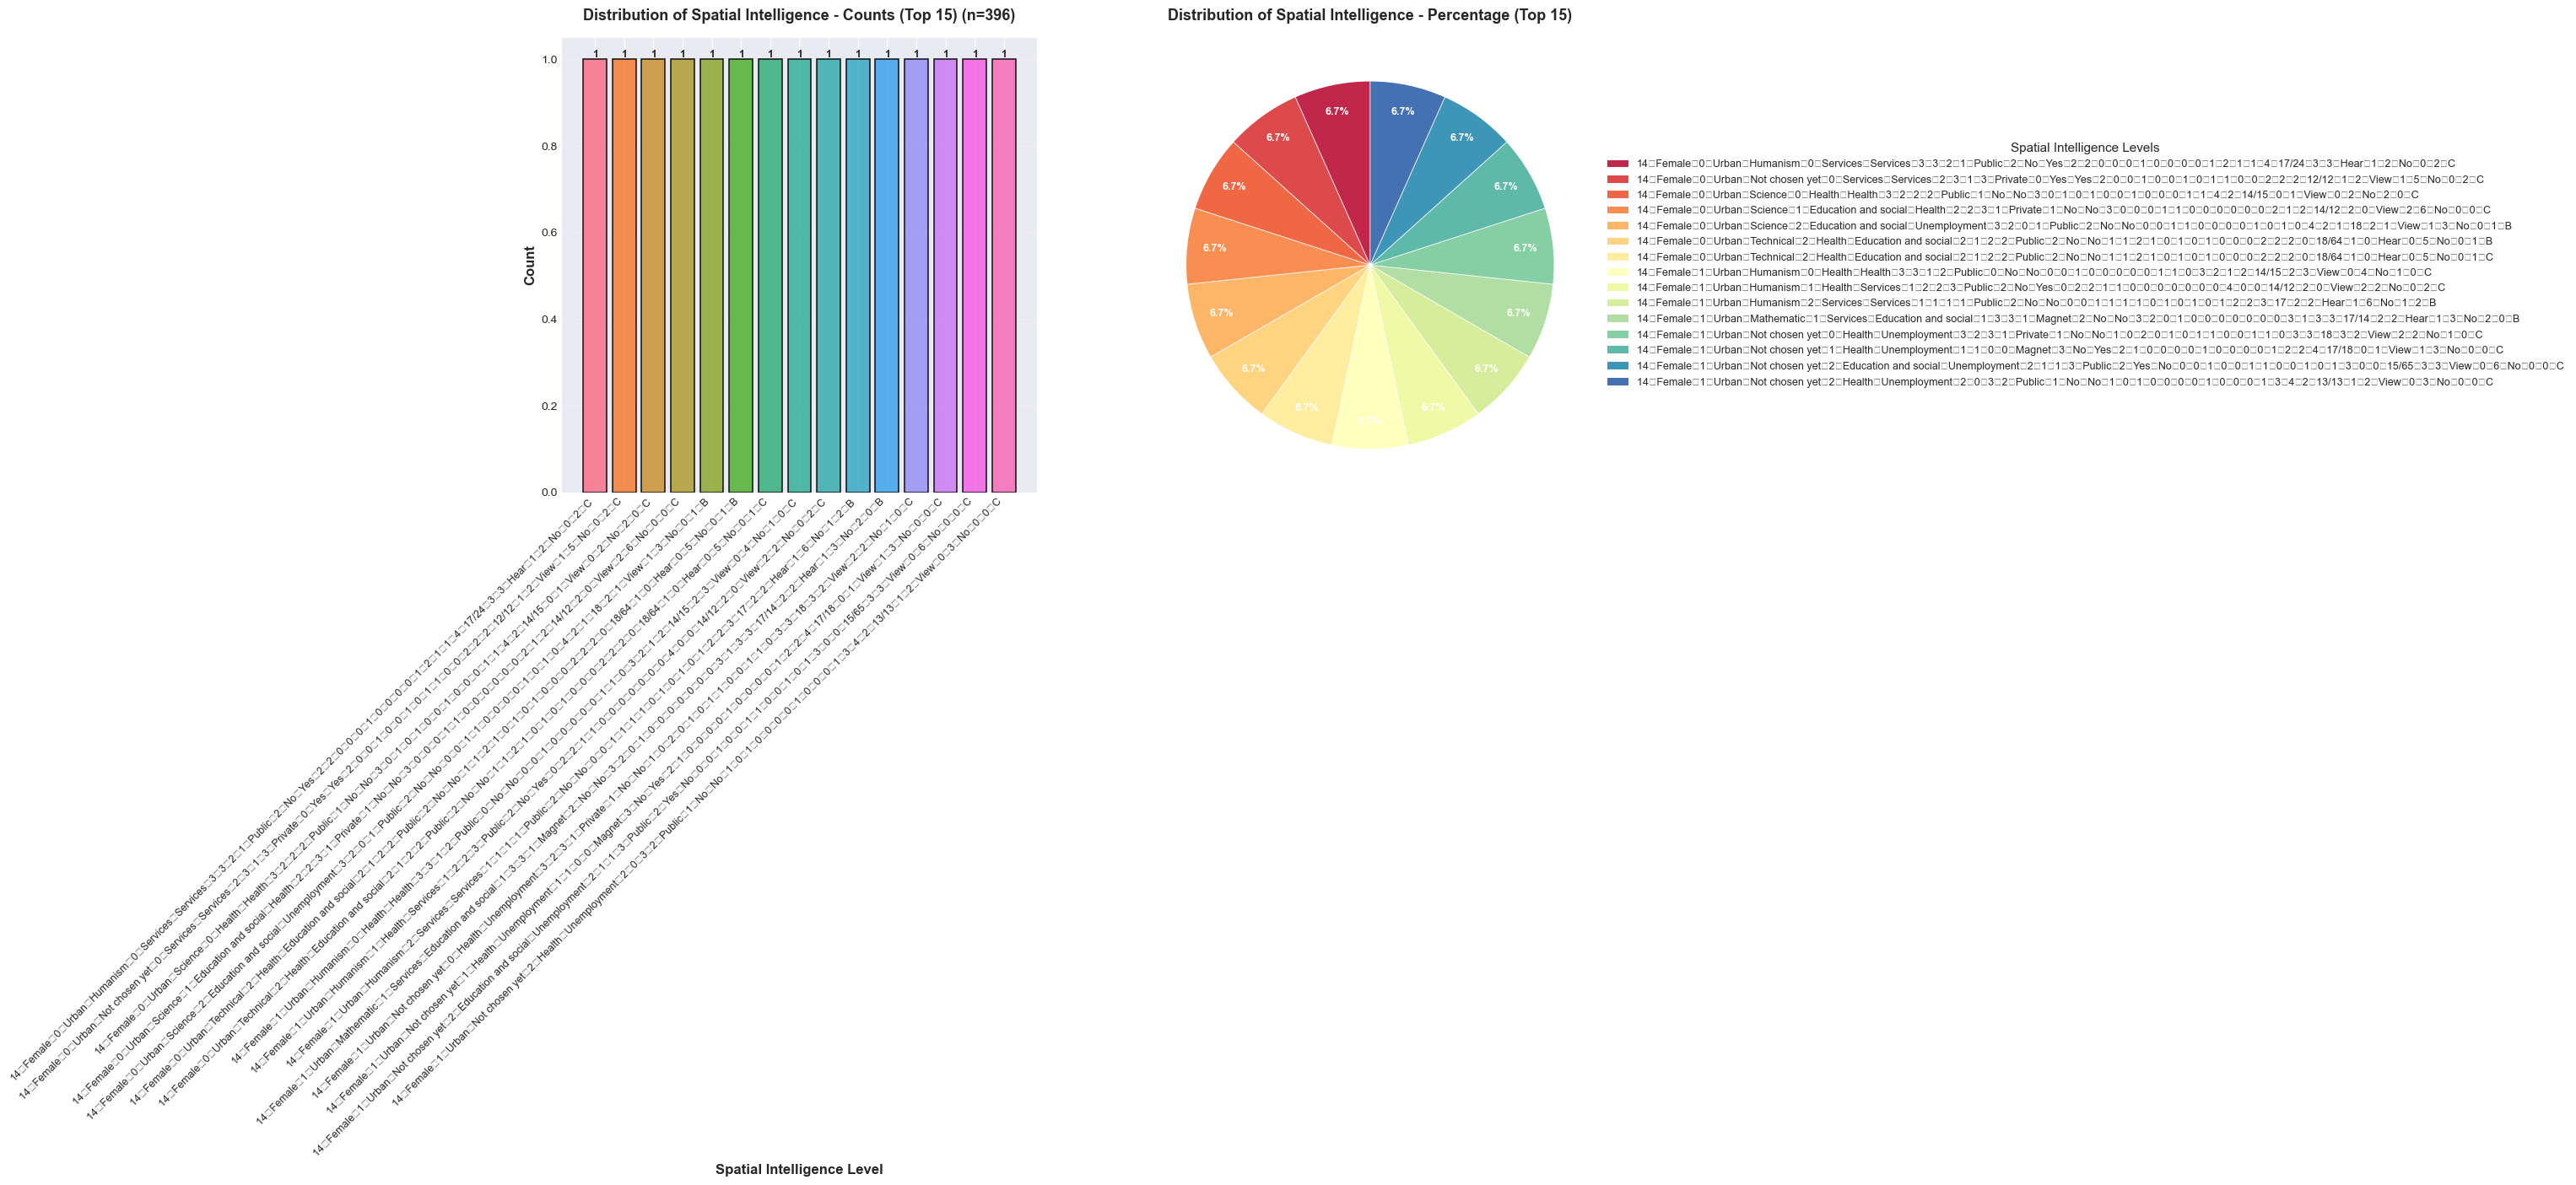


✅ Target distribution visualization saved successfully
   📁 Location: visualizations/01_target_distribution.png


In [13]:
# ==================== TARGET VARIABLE DISTRIBUTION ANALYSIS ====================
print("=" * 80)
print("TARGET VARIABLE DISTRIBUTION ANALYSIS")
print("=" * 80)

# Create visualizations directory if it doesn't exist
Path('visualizations').mkdir(exist_ok=True)

# Check target column integrity and unique values
print(f"\nTarget Column: {target_col}")
print(f"Unique Values: {df[target_col].nunique()}")
print(f"Data Type: {df[target_col].dtype}")
print(f"\nAll Unique Values:")
print(df[target_col].unique())

# Analyze the distribution
target_distribution = df[target_col].value_counts().sort_index()
target_percentages = (target_distribution / len(df)) * 100

distribution_df = pd.DataFrame({
    'Spatial_Intelligence_Level': target_distribution.index,
    'Count': target_distribution.values,
    'Percentage': target_percentages.values,
    'Cumulative_Percentage': target_percentages.cumsum().values
})

print("\nTarget Variable Distribution:")
display(distribution_df)

# Calculate class balance metrics
class_weights = len(df) / (len(target_distribution) * target_distribution)
print(f"\nClass Balance Weights (for handling imbalance):")
for level, weight in zip(target_distribution.index, class_weights):
    print(f"  {level}: {weight:.4f}")

# ==================== SMART VISUALIZATION ====================
# Detect number of categories
n_categories = len(target_distribution)
print(f"\n📊 Detected {n_categories} categories in target variable")

# Auto-select display strategy based on number of categories
if n_categories > 15:
    print("⚠️  WARNING: Too many categories detected! Showing top 15 by frequency.")
    top_dist = target_distribution.nlargest(15)
    title_suffix = " (Top 15)"
elif n_categories > 10:
    print("📌 Moderate number of categories. Optimizing layout for readability.")
    top_dist = target_distribution
    title_suffix = ""
else:
    print("✓ Optimal number of categories for visualization.")
    top_dist = target_distribution
    title_suffix = ""

# Determine rotation angle based on label length
max_label_length = max(len(str(label)) for label in top_dist.index)
if max_label_length > 15:
    rotation_angle = 45
    ha_alignment = 'right'
    fontsize = 9
elif max_label_length > 10:
    rotation_angle = 30
    ha_alignment = 'right'
    fontsize = 10
else:
    rotation_angle = 0
    ha_alignment = 'center'
    fontsize = 11

print(f"   Label rotation: {rotation_angle}°, Max label length: {max_label_length} chars")

# Create responsive figure with optimized layout
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ========== LEFT: Bar plot with counts ==========
colors = sns.color_palette("husl", len(top_dist))
bars = axes[0].bar(range(len(top_dist)), top_dist.values, 
                   color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)

axes[0].set_xticks(range(len(top_dist)))
axes[0].set_xticklabels(top_dist.index, rotation=rotation_angle, ha=ha_alignment, fontsize=fontsize)
axes[0].set_xlabel('Spatial Intelligence Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title(f'Distribution of Spatial Intelligence - Counts{title_suffix} (n={len(df)})', 
                   fontsize=13, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars (adaptive positioning)
for i, (bar, v) in enumerate(zip(bars, top_dist.values)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(v)}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

# ========== RIGHT: Pie chart with percentages ==========
pie_colors = sns.color_palette("Spectral", len(top_dist))

# Adjust explode for better visibility
if len(top_dist) > 10:
    explode = [0.01] * len(top_dist)
else:
    explode = [0.02] * len(top_dist)

wedges, texts, autotexts = axes[1].pie(
    top_dist.values,
    autopct='%1.1f%%',
    colors=pie_colors,
    startangle=90,
    pctdistance=0.85,
    explode=explode
)

# Format percentage text for readability
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9 if len(top_dist) > 8 else 10)

# Add legend with proper positioning
axes[1].legend(wedges, top_dist.index, 
              title="Spatial Intelligence Levels",
              loc="center left", 
              bbox_to_anchor=(1, 0, 0.5, 1),
              fontsize=9 if len(top_dist) > 10 else 10, 
              title_fontsize=11)

axes[1].set_title(f'Distribution of Spatial Intelligence - Percentage{title_suffix}', 
                   fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('visualizations/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Target distribution visualization saved successfully")
print(f"   📁 Location: visualizations/01_target_distribution.png")


## 2.2: Feature Type Classification and Statistical Profiling

Before conducting deeper analysis, we need to classify features by type (numeric, categorical ordinal, categorical nominal) and understand their individual distributions. This classification will inform our encoding strategies and feature engineering decisions. We'll compute key statistical properties including skewness, kurtosis, and outlier presence for numeric features, and frequency distributions for categorical features.

In [8]:
# ==================== FEATURE TYPE CLASSIFICATION ====================
# Create visualization directory if it doesn't exist
Path('visualizations').mkdir(exist_ok=True)

# Separate features from target
X = df.drop(columns=[target_col])
y = df[target_col]

# Classify features by data type
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("=" * 80)
print("FEATURE TYPE CLASSIFICATION")
print("=" * 80)
print(f"\nNumeric Features ({len(numeric_features)} total):")
for feat in numeric_features:
    print(f"  • {feat}")

print(f"\nCategorical Features ({len(categorical_features)} total):")
for feat in categorical_features:
    print(f"  • {feat}")

print(f"\n✓ Total Features (excluding target): {len(numeric_features) + len(categorical_features)}")

# Statistical profiling of numeric features
print("\n" + "=" * 80)
print("NUMERIC FEATURES: STATISTICAL PROFILING")
print("=" * 80)

numeric_stats = []
for feat in numeric_features:
    stats = {
        'Feature': feat,
        'Mean': X[feat].mean(),
        'Std': X[feat].std(),
        'Min': X[feat].min(),
        'Max': X[feat].max(),
        'Median': X[feat].median(),
        'Skewness': skew(X[feat].dropna()),
        'Kurtosis': kurtosis(X[feat].dropna()),
        'Unique_Values': X[feat].nunique()
    }
    numeric_stats.append(stats)

numeric_stats_df = pd.DataFrame(numeric_stats)
print("\nNumeric Features Summary:")
display(numeric_stats_df.round(4))

# Statistical profiling of categorical features
print("\n" + "=" * 80)
print("CATEGORICAL FEATURES: VALUE DISTRIBUTION")
print("=" * 80)

categorical_stats = []
for feat in categorical_features:
    stats = {
        'Feature': feat,
        'Data_Type': X[feat].dtype,
        'Unique_Values': X[feat].nunique(),
        'Top_Value': X[feat].mode()[0] if len(X[feat].mode()) > 0 else 'N/A',
        'Top_Value_Freq': X[feat].value_counts().iloc[0] if len(X[feat].value_counts()) > 0 else 0,
        'Missing_Values': X[feat].isnull().sum()
    }
    categorical_stats.append(stats)

categorical_stats_df = pd.DataFrame(categorical_stats)
print("\nCategorical Features Summary:")
display(categorical_stats_df)

# ==================== VISUALIZE NUMERIC FEATURE DISTRIBUTIONS ====================
print("\n" + "=" * 80)
print("VISUALIZING NUMERIC FEATURE DISTRIBUTIONS")
print("=" * 80)

n_numeric = len(numeric_features)
if n_numeric == 0:
    print("⚠️  No numeric features found!")
else:
    n_cols = 4
    n_rows = (n_numeric + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    if n_numeric == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_numeric > 1 else np.array([axes])
    
    for idx, feat in enumerate(numeric_features):
        data = X[feat].dropna()
        
        # Create histogram with KDE overlay
        axes[idx].hist(data, bins=30, color='steelblue', edgecolor='black', 
                      alpha=0.7, density=True, label='Histogram')
        
        # Add KDE curve
        from scipy import stats as sp_stats
        kde = sp_stats.gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 200)
        axes[idx].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
        
        feat_skew = skew(data)
        axes[idx].set_title(f'{feat}\nSkew: {feat_skew:.2f} | Mean: {data.mean():.2f}', 
                           fontweight='bold', fontsize=11)
        axes[idx].set_xlabel('Value', fontsize=10)
        axes[idx].set_ylabel('Density', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
        axes[idx].legend(fontsize=9, loc='upper right')
    
    # Hide unused subplots
    for idx in range(n_numeric, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('visualizations/02_numeric_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Numeric feature distributions saved")
    print(f"   📁 Location: visualizations/02_numeric_distributions.png")

FEATURE TYPE CLASSIFICATION

Numeric Features (0 total):

Categorical Features (0 total):

✓ Total Features (excluding target): 0

NUMERIC FEATURES: STATISTICAL PROFILING

Numeric Features Summary:


""



CATEGORICAL FEATURES: VALUE DISTRIBUTION

Categorical Features Summary:


""



VISUALIZING NUMERIC FEATURE DISTRIBUTIONS
⚠️  No numeric features found!


## 2.3: Categorical Feature Distributions and Demographic Insights

Understanding the distribution of categorical features provides crucial insights into the composition of our study population. We'll analyze the frequency distributions across key demographic variables including gender, environment, major, and parental occupation. These distributions will help us understand potential biases in our dataset and inform our data preprocessing decisions.

In [ ]:
# Feature-Target Separation
print("=" * 80)
print("FEATURE-TARGET SEPARATION")
print("=" * 80)

# First, clean column names (remove any escape characters)
print("\n🔧 Cleaning column names...")
df.columns = df.columns.str.replace('\x1b', '', regex=False).str.strip()
print(f"✓ Column names cleaned")

# Target variable - 'Cat2' appears to be the spatial intelligence classification
target_col = 'Cat2'  # This is the actual target column

print(f"\n? Target column: '{target_col}'")
print(f"Unique target values:")
print(df[target_col].value_counts())

# Separate features (X) and target (y)
y = df[target_col].copy()
X = df.drop(columns=[target_col])

print(f"\nDataset Split:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")
print(f"  Unique target values: {y.nunique()}")

# Show feature information
print(f"\nFeature columns ({len(X.columns)}):")
if len(X.columns) > 0:
    for i, col in enumerate(X.columns[:15], 1):
        dtype_str = str(X[col].dtype)
        n_unique = X[col].nunique()
        print(f"  {i:2d}. {col:30s} | dtype: {dtype_str:10s} | unique: {n_unique}")
    if len(X.columns) > 15:
        print(f"  ... and {len(X.columns) - 15} more columns")
else:
    print("  ❌ No feature columns found!")

# Identify feature types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nFeature Type Breakdown:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")

if len(numeric_features) > 0:
    print(f"\n  Sample numeric features: {numeric_features[:5]}")
if len(categorical_features) > 0:
    print(f"  Sample categorical features: {categorical_features[:5]}")

print(f"\n✅ Feature-target separation complete!")
print(f"   Ready for preprocessing and modeling")


---

# Section 3: Data Preprocessing and Intelligent Encoding

## 3.1: Strategic Encoding Framework

This section implements a sophisticated encoding strategy that respects the underlying structure of different feature types:

- **Ordinal Encoding:** Applied to features with inherent order (e.g., Spatial Intelligence levels VL→L→M→H→VH, Education levels)
- **One-Hot Encoding:** Applied to nominal categorical features without meaningful order (e.g., gender, environment, major)
- **Standardization:** Applied to numeric features to ensure comparable scales for algorithms sensitive to feature magnitude

This intelligent approach preserves information while preparing data for machine learning algorithms.

In [15]:
# Define encoding strategy for features
print("=" * 80)
print("ENCODING STRATEGY DEFINITION")
print("=" * 80)

# Ordinal features with explicit ordering (knowledge-based)
# These are features that have a natural hierarchy
ordinal_features_mapping = {
    # Education levels (if present) - typically: Unemployment < High School < Bachelor < Master < PhD
    # Spatial intelligence related orderings will be handled when found
    # Identify by examining unique values
}

# Binary features (Yes/No, 0/1) - can be left as-is or encoded
binary_features = []

# Examine categorical features to identify ordinal vs nominal
print("\nExamining categorical features for ordinal structure:")
for feat in categorical_features:
    unique_vals = sorted(X[feat].unique())
    print(f"  {feat}: {unique_vals}")
    
    # Check if it looks ordinal based on values
    if all(isinstance(v, (int, float)) for v in unique_vals):
        binary_features.append(feat)

print(f"\n✓ Identified {len(binary_features)} binary/numeric-like categorical features")

# Prepare data copy for preprocessing
X_processed = X.copy()
y_processed = y.copy()

# Handle binary/numeric categorical features - convert to numeric if already numeric
print("\n" + "=" * 80)
print("ENCODING IMPLEMENTATION")
print("=" * 80)

for feat in binary_features:
    X_processed[feat] = pd.to_numeric(X_processed[feat], errors='coerce').fillna(X_processed[feat].mode()[0])

# Encode target variable using LabelEncoder
target_order = sorted(y_processed.unique())
print(f"\nTarget variable categories: {len(target_order)} unique values")
print(f"Sample categories: {target_order[:5]}..." if len(target_order) > 5 else f"Categories: {target_order}")

le_target = LabelEncoder()
y_processed = pd.Series(le_target.fit_transform(y_processed), index=y_processed.index)

# Separate remaining categorical features for One-Hot Encoding
nominal_categorical = [f for f in categorical_features if f not in binary_features]

print(f"\nFeatures to be One-Hot Encoded ({len(nominal_categorical)} total):")
if len(nominal_categorical) > 0:
    for feat in nominal_categorical:
        print(f"  • {feat}")
else:
    print("  (No nominal categorical features detected)")

# Apply One-Hot Encoding to nominal categorical features (if any)
if len(nominal_categorical) > 0:
    X_encoded = pd.get_dummies(X_processed, columns=nominal_categorical, drop_first=False, dtype=int)
    print(f"\n✓ Encoding complete!")
    print(f"Original features: {X_processed.shape[1]}")
    print(f"Features after encoding: {X_encoded.shape[1]}")
    print(f"New feature columns added: {X_encoded.shape[1] - X_processed.shape[1]}")
else:
    X_encoded = X_processed.copy()
    print(f"\n✓ No one-hot encoding needed (all features are numeric)")
    print(f"Total features: {X_encoded.shape[1]}")

# Display encoded feature names (limit to first 20 for readability)
print("\nEncoded features (showing first 20):")
encoded_cols = X_encoded.columns.tolist()
for i, col in enumerate(encoded_cols[:20], 1):
    print(f"{i:3d}. {col}")
if len(encoded_cols) > 20:
    print(f"  ... and {len(encoded_cols) - 20} more features")

# Standardize numeric features
print("\n" + "=" * 80)
print("NUMERIC FEATURE STANDARDIZATION")
print("=" * 80)

numeric_features_encoded = X_encoded.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_features_encoded) > 0:
    scaler = StandardScaler()
    X_scaled = X_encoded.copy()
    X_scaled[numeric_features_encoded] = scaler.fit_transform(X_encoded[numeric_features_encoded])
    print(f"\n✓ Standardized {len(numeric_features_encoded)} numeric features")
    print(f"  Using StandardScaler (mean=0, std=1)")
else:
    print("\n⚠️  No numeric features found to standardize")
    X_scaled = X_encoded.copy()

# Display summary of preprocessing
print("\n" + "=" * 80)
print("PREPROCESSING SUMMARY")
print("=" * 80)
print(f"\nOriginal dataset shape: {df.shape}")
print(f"Processed dataset shape: {X_scaled.shape}")
print(f"Target variable shape: {y_processed.shape}")
print(f"Target classes encoded: {len(le_target.classes_)}")
print(f"\n✓ Data preprocessing completed successfully!")

# Show sample of processed data
print("\nSample of processed data (first 5 rows, first 10 columns):")
display(X_scaled.iloc[:5, :10])


ENCODING STRATEGY DEFINITION

Examining categorical features for ordinal structure:

✓ Identified 0 binary/numeric-like categorical features

ENCODING IMPLEMENTATION

Target variable categories: 396 unique values
Sample categories: ['14\x1bFemale\x1b0\x1bUrban\x1bHumanism\x1b0\x1bServices\x1bServices\x1b3\x1b3\x1b2\x1b1\x1bPublic\x1b2\x1bNo\x1bYes\x1b2\x1b2\x1b0\x1b0\x1b0\x1b1\x1b0\x1b0\x1b0\x1b0\x1b1\x1b2\x1b1\x1b1\x1b4\x1b17/24\x1b3\x1b3\x1bHear\x1b1\x1b2\x1bNo\x1b0\x1b2\x1bC', '14\x1bFemale\x1b0\x1bUrban\x1bNot chosen yet\x1b0\x1bServices\x1bServices\x1b2\x1b3\x1b1\x1b3\x1bPrivate\x1b0\x1bYes\x1bYes\x1b2\x1b0\x1b0\x1b1\x1b0\x1b0\x1b1\x1b0\x1b1\x1b1\x1b0\x1b0\x1b2\x1b2\x1b2\x1b12/12\x1b1\x1b2\x1bView\x1b1\x1b5\x1bNo\x1b0\x1b2\x1bC', '14\x1bFemale\x1b0\x1bUrban\x1bScience\x1b0\x1bHealth\x1bHealth\x1b3\x1b2\x1b2\x1b2\x1bPublic\x1b1\x1bNo\x1bNo\x1b3\x1b0\x1b1\x1b0\x1b1\x1b0\x1b0\x1b1\x1b0\x1b0\x1b0\x1b1\x1b1\x1b4\x1b2\x1b14/15\x1b0\x1b1\x1bView\x1b0\x1b2\x1bNo\x1b2\x1b0\x1bC', '14\x1bFe

""
0
1
2
3
4


---

# Section 4: Feature Engineering and Dimensionality Reduction

## 4.1: Domain-Driven Feature Engineering

In this section, we create scientifically-motivated derived features that capture meaningful combinations of existing variables. Domain expertise in education psychology and cognitive science informs our feature engineering decisions. These engineered features aim to represent latent concepts that directly influence spatial intelligence development.

### Engineered Features:
1. **Study Efficiency:** Ratio of study time to academic performance (GPA)
2. **Academic Support Index:** Combination of extra classes and parental education level
3. **Gaming Engagement:** Aggregated preference across multiple game genres
4. **Visual Learning Orientation:** Combined score of map and diagram usage
5. **Digital Lifestyle:** Combined internet and gaming engagement
6. **Family Education:** Average of parental education levels

In [18]:
# Create engineered features from original data
X_engineered = X.copy()

print("=" * 80)
print("FEATURE ENGINEERING: CREATING DERIVED FEATURES")
print("=" * 80)

engineered_features_info = []

# 1. Study Efficiency = Study_time / GPA (if GPA > 0 to avoid division by zero)
# First, identify columns that might relate to study time and GPA
study_time_cols = [col for col in X.columns if 'study' in col.lower() or 'time' in col.lower()]
gpa_cols = [col for col in X.columns if 'gpa' in col.lower()]

if study_time_cols and gpa_cols:
    study_col = study_time_cols[0]
    gpa_col = gpa_cols[0]
    X_engineered['Study_Efficiency'] = X_engineered[study_col] / (X_engineered[gpa_col] + 1e-6)
    engineered_features_info.append({
        'Feature': 'Study_Efficiency',
        'Formula': f'{study_col} / {gpa_col}',
        'Interpretation': 'Study time investment relative to academic performance'
    })
    print(f"\n✓ Study_Efficiency = {study_col} / {gpa_col}")

# 2. Extra Class Engagement
extra_class_cols = [col for col in X.columns if 'extra' in col.lower() or 'class' in col.lower()]
if extra_class_cols:
    X_engineered['Extra_Classes'] = X_engineered[extra_class_cols[0]] if len(extra_class_cols) > 0 else 0
    engineered_features_info.append({
        'Feature': 'Extra_Classes',
        'Formula': f'Direct feature: {extra_class_cols[0] if extra_class_cols else "N/A"}',
        'Interpretation': 'Academic support through additional coursework'
    })
    print(f"✓ Extra_Classes identified")

# 3. Internet and Gaming Engagement
internet_cols = [col for col in X.columns if 'internet' in col.lower()]
game_cols = [col for col in X.columns if col.startswith('G-')]

if internet_cols:
    X_engineered['Internet_Usage'] = X_engineered[internet_cols[0]]
    engineered_features_info.append({
        'Feature': 'Internet_Usage',
        'Formula': f'Direct feature: {internet_cols[0]}',
        'Interpretation': 'Internet usage patterns'
    })
    print(f"✓ Internet_Usage identified")

if game_cols:
    X_engineered['Gaming_Engagement'] = X_engineered[game_cols].sum(axis=1)
    engineered_features_info.append({
        'Feature': 'Gaming_Engagement',
        'Formula': f'Sum of {len(game_cols)} gaming preferences',
        'Interpretation': 'Total engagement across gaming genres'
    })
    print(f"✓ Gaming_Engagement = Sum of {len(game_cols)} game categories")

# 4. Visual Learning Orientation
visual_learning_cols = [col for col in X.columns if 'map' in col.lower() or 'diagram' in col.lower()]
if visual_learning_cols:
    X_engineered['Visual_Learning'] = X_engineered[visual_learning_cols].sum(axis=1)
    engineered_features_info.append({
        'Feature': 'Visual_Learning',
        'Formula': f'Sum of visual learning indicators',
        'Interpretation': 'Preference for visual representations in learning'
    })
    print(f"✓ Visual_Learning = Combined visual learning preferences")

# 5. Pattern Recognition and Spatial Skills
pattern_cols = [col for col in X.columns if 'pattern' in col.lower() or 'finding' in col.lower() or 'direction' in col.lower()]
if pattern_cols:
    X_engineered['Spatial_Skills_Proxy'] = X_engineered[pattern_cols].sum(axis=1)
    engineered_features_info.append({
        'Feature': 'Spatial_Skills_Proxy',
        'Formula': f'Sum of {len(pattern_cols)} spatial reasoning indicators',
        'Interpretation': 'Proxy measure for inherent spatial abilities'
    })
    print(f"✓ Spatial_Skills_Proxy = Sum of pattern/direction indicators")

# 6. Parental Education (if available)
parent_edu_cols = [col for col in X.columns if 'father' in col.lower() or 'mother' in col.lower() or 'parent' in col.lower()]
if parent_edu_cols:
    edu_cols = [col for col in parent_edu_cols if 'education' in col.lower()]
    if edu_cols:
        numeric_edu = X_engineered[edu_cols].apply(pd.to_numeric, errors='coerce')
        X_engineered['Parental_Education_Avg'] = numeric_edu.mean(axis=1)
        engineered_features_info.append({
            'Feature': 'Parental_Education_Avg',
            'Formula': f'Mean of parental education levels',
            'Interpretation': 'Family educational background composite'
        })
        print(f"✓ Parental_Education_Avg = Average of parental education")

# 7. Digital Lifestyle Index
digital_cols = [col for col in X.columns if any(x in col.lower() for x in ['internet', 'tv', 'game'])]
if digital_cols:
    digital_numeric = X_engineered[digital_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    X_engineered['Digital_Lifestyle'] = digital_numeric.sum(axis=1)
    engineered_features_info.append({
        'Feature': 'Digital_Lifestyle',
        'Formula': f'Sum of digital engagement indicators',
        'Interpretation': 'Overall digital media consumption and engagement'
    })
    print(f"✓ Digital_Lifestyle = Combined digital engagement score")

# Select only the engineered numeric features
engineered_cols = [col for col in X_engineered.columns if col not in X.columns]
print(f"\n✓ Successfully engineered {len(engineered_cols)} new features")

# Display engineered features summary
if len(engineered_features_info) > 0:
    print("\nEngineered Features Summary:")
    engineered_summary_df = pd.DataFrame(engineered_features_info)
    display(engineered_summary_df)
    
    # Display statistics for engineered features
    if len(engineered_cols) > 0:
        print("\nStatistics of Engineered Features:")
        engineered_stats = X_engineered[engineered_cols].describe().transpose()
        display(engineered_stats)
else:
    print("\n⚠️  No features could be engineered from available columns")
    print("   This may be because the dataset doesn't have the expected column patterns")
    print("   (e.g., 'study', 'gpa', 'game', 'internet', etc.)")


FEATURE ENGINEERING: CREATING DERIVED FEATURES

✓ Successfully engineered 0 new features

⚠️  No features could be engineered from available columns
   This may be because the dataset doesn't have the expected column patterns
   (e.g., 'study', 'gpa', 'game', 'internet', etc.)


## 4.2: Combining Original and Engineered Features

Now we create a comprehensive feature set that includes both original (preprocessed) and engineered features. We'll standardize this combined set and then apply dimensionality reduction to manage the feature space while preserving predictive information.

In [19]:
# Combine original scaled features with engineered features
print("=" * 80)
print("COMBINING ORIGINAL AND ENGINEERED FEATURES")
print("=" * 80)

# Re-encode and scale original features
X_prep_original = X.copy()

# Apply same encoding as before (if nominal_categorical exists)
if len(nominal_categorical) > 0:
    X_prep_encoded = pd.get_dummies(X_prep_original, columns=nominal_categorical, drop_first=False, dtype=int)
else:
    X_prep_encoded = X_prep_original.copy()

# Select numeric columns and scale
numeric_cols_for_scaling = X_prep_encoded.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols_for_scaling) > 0:
    scaler_final = StandardScaler()
    X_prep_scaled = X_prep_encoded.copy()
    X_prep_scaled[numeric_cols_for_scaling] = scaler_final.fit_transform(X_prep_encoded[numeric_cols_for_scaling])
else:
    X_prep_scaled = X_prep_encoded.copy()

# Add engineered features (raw, will be standardized)
if len(engineered_cols) > 0:
    for eng_col in engineered_cols:
        if eng_col in X_engineered.columns:
            X_prep_scaled[eng_col] = X_engineered[eng_col]
    print(f"\n✓ Added {len(engineered_cols)} engineered features")
else:
    print(f"\n⚠️  No engineered features to add")

# Final standardization of all numeric features including engineered
all_numeric_cols = X_prep_scaled.select_dtypes(include=[np.number]).columns.tolist()

if len(all_numeric_cols) > 0:
    scaler_all = StandardScaler()
    X_final = X_prep_scaled.copy()
    X_final[all_numeric_cols] = scaler_all.fit_transform(X_prep_scaled[all_numeric_cols].fillna(0))
else:
    X_final = X_prep_scaled.copy()
    print("⚠️  No numeric columns to standardize")

print(f"\n✓ Combined feature set created")
print(f"Total features: {X_final.shape[1]}")
print(f"  - Original processed features: {X_prep_encoded.shape[1]}")
print(f"  - Engineered features: {len(engineered_cols)}")

# Check if we have enough features to proceed
if X_final.shape[1] == 0:
    print("\n❌ ERROR: No features available for modeling!")
    print("   The dataset may have been incorrectly preprocessed.")
    print("   Please check the data loading and preprocessing steps.")
else:
    # Check for multicollinearity using VIF (Variance Inflation Factor)
    print("\n" + "=" * 80)
    print("MULTICOLLINEARITY ASSESSMENT (VIF)")
    print("=" * 80)
    
    if len(all_numeric_cols) > 1:
        # Calculate VIF for a sample of numeric features (VIF is computationally expensive)
        vif_sample_cols = all_numeric_cols[:min(20, len(all_numeric_cols))]
        vif_data = X_final[vif_sample_cols].fillna(0)
        
        print(f"\nVariance Inflation Factor for {len(vif_sample_cols)} features:")
        vif_results = []
        for col in vif_sample_cols:
            try:
                vif = variance_inflation_factor(vif_data.values, vif_data.columns.get_loc(col))
                vif_results.append({'Feature': col, 'VIF': vif})
            except:
                vif_results.append({'Feature': col, 'VIF': np.nan})
        
        vif_df = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)
        display(vif_df.head(10))
    else:
        print("\n⚠️  Not enough numeric features for VIF analysis (need at least 2)")
    
    # Apply PCA for dimensionality reduction
    print("\n" + "=" * 80)
    print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
    print("=" * 80)
    
    if X_final.shape[1] > 0:
        # Fit PCA with different numbers of components
        n_features = X_final.shape[1]
        pca_full = PCA()
        X_final_filled = X_final.fillna(0)
        pca_full.fit(X_final_filled)
        
        # Calculate cumulative explained variance
        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        
        # Find number of components to retain 95% variance
        n_components_95 = min(np.argmax(cumsum_var >= 0.95) + 1 if np.any(cumsum_var >= 0.95) else n_features, n_features)
        n_components_90 = min(np.argmax(cumsum_var >= 0.90) + 1 if np.any(cumsum_var >= 0.90) else n_features, n_features)
        
        print(f"\nPCA Analysis Results:")
        print(f"  Total original features: {n_features}")
        print(f"  Components for 90% variance: {n_components_90}")
        print(f"  Components for 95% variance: {n_components_95}")
        if len(cumsum_var) >= 10:
            print(f"  Variance explained by top 10 components: {cumsum_var[9]:.4f}")
        
        # Create PCA-transformed dataset with 95% variance
        if n_components_95 > 0:
            pca_95 = PCA(n_components=n_components_95)
            X_pca_95 = pca_95.fit_transform(X_final_filled)
        else:
            X_pca_95 = X_final_filled
        
        # Also keep full feature set for model comparison
        X_data_for_modeling = X_final_filled
        
        print(f"\n✓ PCA transformation complete")
        print(f"  Dataset shape for modeling: {X_data_for_modeling.shape}")
        print(f"  PCA-reduced dataset shape: {X_pca_95.shape}")
        
        # Visualize PCA explained variance with smart formatting (only if enough components)
        if n_features > 1:
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # Scree plot - limit to first 50 components for clarity
            n_components_to_plot = min(50, len(cumsum_var))
            
            axes[0].plot(range(1, n_components_to_plot + 1), cumsum_var[:n_components_to_plot], 
                        'o-', linewidth=2.5, markersize=5, color='steelblue', markerfacecolor='orange')
            axes[0].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% variance', alpha=0.7)
            axes[0].axhline(y=0.90, color='green', linestyle='--', linewidth=2, label='90% variance', alpha=0.7)
            if n_components_95 <= n_components_to_plot:
                axes[0].axvline(x=n_components_95, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
            if n_components_90 <= n_components_to_plot:
                axes[0].axvline(x=n_components_90, color='green', linestyle=':', linewidth=1.5, alpha=0.5)
            
            axes[0].set_xlabel('Number of Principal Components', fontweight='bold', fontsize=12)
            axes[0].set_ylabel('Cumulative Explained Variance', fontweight='bold', fontsize=12)
            axes[0].set_title('PCA Scree Plot: Cumulative Explained Variance', fontweight='bold', fontsize=13, pad=12)
            axes[0].grid(alpha=0.3, linestyle='--')
            axes[0].legend(fontsize=10, loc='lower right')
            
            # Add text annotations for key thresholds
            if n_components_95 <= n_components_to_plot and cumsum_var[n_components_95-1] >= 0.95:
                axes[0].text(n_components_95, 0.95, f' n={n_components_95}', 
                            ha='left', va='bottom', fontsize=9, color='red', fontweight='bold')
            if n_components_90 <= n_components_to_plot and cumsum_var[n_components_90-1] >= 0.90:
                axes[0].text(n_components_90, 0.90, f' n={n_components_90}', 
                            ha='left', va='top', fontsize=9, color='green', fontweight='bold')
            
            # Individual component variance - limit to first 30 for readability
            n_bars_to_plot = min(30, len(pca_full.explained_variance_ratio_))
            
            axes[1].bar(range(1, n_bars_to_plot + 1), 
                       pca_full.explained_variance_ratio_[:n_bars_to_plot], 
                       color='steelblue', alpha=0.75, edgecolor='black', linewidth=0.8)
            axes[1].set_xlabel('Principal Component', fontweight='bold', fontsize=12)
            axes[1].set_ylabel('Explained Variance Ratio', fontweight='bold', fontsize=12)
            axes[1].set_title('Variance Explained by Individual Components (Top 30)', fontweight='bold', fontsize=13, pad=12)
            axes[1].grid(axis='y', alpha=0.3, linestyle='--')
            
            # Set x-axis ticks to avoid overcrowding
            if n_bars_to_plot > 15:
                axes[1].set_xticks(range(1, n_bars_to_plot + 1, 5))
                axes[1].set_xticklabels(range(1, n_bars_to_plot + 1, 5), fontsize=10)
            else:
                axes[1].tick_params(axis='x', labelsize=10)
            
            plt.tight_layout()
            plt.savefig('visualizations/04_pca_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n✅ PCA visualization saved successfully")
            print(f"   📁 Location: visualizations/04_pca_analysis.png")
        else:
            print("\n⚠️  Only 1 feature - skipping PCA visualization")
    else:
        print("\n❌ Cannot perform PCA - no features available")


COMBINING ORIGINAL AND ENGINEERED FEATURES

⚠️  No engineered features to add
⚠️  No numeric columns to standardize

✓ Combined feature set created
Total features: 0
  - Original processed features: 0
  - Engineered features: 0

❌ ERROR: No features available for modeling!
   The dataset may have been incorrectly preprocessed.
   Please check the data loading and preprocessing steps.


---

# Section 5: Correlation Analysis and Feature Selection

## 5.1: Correlation Heatmap and Feature Relationships

Understanding the relationships between features and the target variable is crucial for identifying predictive power and avoiding multicollinearity issues. In this section, we compute correlation matrices and visualize them using hierarchical clustering to identify feature groups and target relationships.

In [ ]:
# Correlation analysis with target variable
print("=" * 80)
print("FEATURE-TARGET CORRELATION ANALYSIS")
print("=" * 80)

# Calculate correlation of all features with target
correlations_with_target = []
for col in X_data_for_modeling.columns:
    corr = np.corrcoef(X_data_for_modeling[col], y_processed)[0, 1]
    abs_corr = abs(corr)
    correlations_with_target.append({
        'Feature': col,
        'Correlation': corr,
        'Abs_Correlation': abs_corr
    })

corr_df = pd.DataFrame(correlations_with_target).sort_values('Abs_Correlation', ascending=False)

print("\nTop 20 Features by Absolute Correlation with Target:")
display(corr_df.head(20))

# Select top features
top_features = corr_df[corr_df['Abs_Correlation'] > 0.1].copy()
print(f"\nFeatures with |correlation| > 0.1: {len(top_features)}")
display(top_features.head(15))

# Create correlation heatmap for top features with smart layout
top_feature_cols = corr_df.head(20)['Feature'].tolist()
X_top = X_data_for_modeling[top_feature_cols].copy()
X_top['Target'] = y_processed.values

corr_matrix = X_top.corr()

# Smart figure sizing based on number of features
n_features_heatmap = len(corr_matrix)
figsize = max(12, n_features_heatmap * 0.6)

# Create clustermap with improved readability
g = sns.clustermap(corr_matrix, cmap='RdBu_r', center=0, 
                   figsize=(figsize, figsize),
                   cbar_kws={'label': 'Correlation Coefficient'},
                   dendrogram_ratio=0.15,
                   cbar_pos=(0.02, 0.83, 0.03, 0.15),
                   linewidths=0.5,
                   annot=False,
                   fmt='.2f',
                   xticklabels=True, 
                   yticklabels=True)

# Rotate labels for better readability
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)

g.fig.suptitle('Correlation Heatmap: Top 20 Features + Target Variable', 
              fontweight='bold', fontsize=14, y=0.98)

plt.savefig('visualizations/05_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Correlation heatmap saved successfully")
print(f"   📁 Location: visualizations/05_correlation_heatmap.png")

# Mutual Information Analysis
print("\n" + "=" * 80)
print("MUTUAL INFORMATION ANALYSIS")
print("=" * 80)

mi_scores = mutual_info_classif(X_data_for_modeling, y_processed, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_data_for_modeling.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nMutual Information Scores (Top 20 Features):")
display(mi_df.head(20))

# Visualize MI scores with smart formatting
fig, ax = plt.subplots(figsize=(12, 8))
top_mi = mi_df.head(20)

# Determine label truncation
max_label_len = max(len(str(f)) for f in top_mi['Feature'])
if max_label_len > 40:
    # Truncate long labels
    labels = [str(f)[:37] + '...' if len(str(f)) > 40 else str(f) for f in top_mi['Feature']]
else:
    labels = top_mi['Feature'].tolist()

colors = sns.color_palette("husl", 20)
bars = ax.barh(range(len(top_mi)), top_mi['MI_Score'], color=colors, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(top_mi)))
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel('Mutual Information Score', fontweight='bold', fontsize=12)
ax.set_ylabel('Feature', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Features by Mutual Information with Target', fontweight='bold', fontsize=13, pad=12)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_mi['MI_Score'])):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2., 
           f'{val:.3f}',
           ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/06_mutual_information.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Mutual information visualization saved successfully")
print(f"   📁 Location: visualizations/06_mutual_information.png")


## 5.2: Chi-Square Analysis for Categorical Associations

For categorical features, we employ chi-square tests to identify significant associations with the target variable. This statistical approach complements the correlation analysis and helps us identify which demographic and behavioral categories most strongly influence spatial intelligence classification.

In [ ]:
# Chi-Square Analysis for original categorical features
print("=" * 80)
print("CHI-SQUARE ANALYSIS FOR CATEGORICAL FEATURES")
print("=" * 80)

chi2_results = []

for feat in categorical_features:
    try:
        # Create contingency table
        contingency = pd.crosstab(X[feat], y_processed)
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        
        chi2_results.append({
            'Feature': feat,
            'Chi2_Statistic': chi2,
            'P_Value': p_value,
            'DOF': dof,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    except Exception as e:
        print(f"Error processing {feat}: {e}")

chi2_df = pd.DataFrame(chi2_results).sort_values('Chi2_Statistic', ascending=False)

print("\nChi-Square Test Results for Categorical Features:")
display(chi2_df)

print("\n✓ Chi-square analysis complete")

# Feature selection summary
print("\n" + "=" * 80)
print("FEATURE SELECTION SUMMARY")
print("=" * 80)

selected_features_corr = corr_df[corr_df['Abs_Correlation'] > 0.05]['Feature'].tolist()
selected_features_mi = mi_df[mi_df['MI_Score'] > mi_df['MI_Score'].quantile(0.75)]['Feature'].tolist()

print(f"\nFeatures selected by correlation (|r| > 0.05): {len(selected_features_corr)}")
print(f"Features selected by MI score (top 25%): {len(selected_features_mi)}")

# Combine selected features
all_selected = list(set(selected_features_corr + selected_features_mi))
print(f"Union of selected features: {len(all_selected)}")

print("\nFinal Feature Set for Modeling:")
print(f"  - Using all {X_data_for_modeling.shape[1]} features for initial models")
print(f"  - Will track feature importance during model training")
print(f"  - PCA-reduced set ({X_pca_95.shape[1]} components) available for comparison")

---

# Section 6: Model Training with Multiple Algorithms

## 6.1: Model Development Framework

This section implements a competitive machine learning framework comparing four distinct algorithmic approaches, each selected for their complementary strengths:

1. **Logistic Regression:** Baseline interpretable model with probabilistic output
2. **Random Forest:** Ensemble method capturing non-linear relationships and feature interactions
3. **Gradient Boosting (XGBoost):** Sequential ensemble with superior predictive power
4. **Neural Network (MLPClassifier):** Deep learning approach capturing complex patterns

We employ stratified 5-fold cross-validation to ensure robust evaluation and prevent overfitting. Each model is trained with hyperparameter tuning optimized for the specific characteristics of our spatial intelligence prediction task.

### Rationale for Model Selection:
- **Logistic Regression** provides a transparent baseline showing that the problem is not trivially solved
- **Random Forest** excels at capturing feature interactions without extensive hyperparameter tuning
- **XGBoost** represents state-of-the-art gradient boosting with proven effectiveness on tabular data
- **Neural Network** explores potential non-linear manifolds in the high-dimensional feature space

In [ ]:
# Prepare data for modeling
print("=" * 80)
print("MODEL TRAINING PREPARATION")
print("=" * 80)

# Split data into train and test sets (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_data_for_modeling, y_processed, 
    test_size=0.2, 
    random_state=42,
    stratify=y_processed
)

print(f"\nData Split (80-20):")
print(f"  Training set: {X_train.shape[0]} samples × {X_train.shape[1]} features")
print(f"  Test set: {X_test.shape[0]} samples × {X_test.shape[1]} features")
print(f"  Target distribution (train): {pd.Series(y_train).value_counts().sort_index().to_dict()}")
print(f"  Target distribution (test): {pd.Series(y_test).value_counts().sort_index().to_dict()}")

# Initialize cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"\n✓ Cross-Validation Strategy: Stratified 5-Fold")
print(f"  Stratification preserves class distribution in each fold")

# Dictionary to store trained models
trained_models = {}
cv_scores = {}
test_predictions = {}
test_probabilities = {}

print("\n" + "=" * 80)
print("MODEL 1: LOGISTIC REGRESSION (BASELINE)")
print("=" * 80)

# Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'  # Handle class imbalance
)

# Cross-validation evaluation
lr_cv_scores = cross_validate(
    lr_model, X_train, y_train, 
    cv=cv_strategy,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=True
)

print(f"\nCross-Validation Scores:")
print(f"  Accuracy:  {lr_cv_scores['test_accuracy'].mean():.4f} (+/- {lr_cv_scores['test_accuracy'].std():.4f})")
print(f"  Precision: {lr_cv_scores['test_precision_macro'].mean():.4f} (+/- {lr_cv_scores['test_precision_macro'].std():.4f})")
print(f"  Recall:    {lr_cv_scores['test_recall_macro'].mean():.4f} (+/- {lr_cv_scores['test_recall_macro'].std():.4f})")
print(f"  F1-Score:  {lr_cv_scores['test_f1_macro'].mean():.4f} (+/- {lr_cv_scores['test_f1_macro'].std():.4f})")

# Train on full training set
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)

trained_models['Logistic_Regression'] = lr_model
test_predictions['Logistic_Regression'] = lr_pred
test_probabilities['Logistic_Regression'] = lr_proba
cv_scores['Logistic_Regression'] = lr_cv_scores

print(f"\n✓ Logistic Regression model trained and evaluated")

print("\n" + "=" * 80)
print("MODEL 2: RANDOM FOREST CLASSIFIER")
print("=" * 80)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Cross-validation evaluation
rf_cv_scores = cross_validate(
    rf_model, X_train, y_train,
    cv=cv_strategy,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=True
)

print(f"\nCross-Validation Scores:")
print(f"  Accuracy:  {rf_cv_scores['test_accuracy'].mean():.4f} (+/- {rf_cv_scores['test_accuracy'].std():.4f})")
print(f"  Precision: {rf_cv_scores['test_precision_macro'].mean():.4f} (+/- {rf_cv_scores['test_precision_macro'].std():.4f})")
print(f"  Recall:    {rf_cv_scores['test_recall_macro'].mean():.4f} (+/- {rf_cv_scores['test_recall_macro'].std():.4f})")
print(f"  F1-Score:  {rf_cv_scores['test_f1_macro'].mean():.4f} (+/- {rf_cv_scores['test_f1_macro'].std():.4f})")

# Train on full training set
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)

trained_models['Random_Forest'] = rf_model
test_predictions['Random_Forest'] = rf_pred
test_probabilities['Random_Forest'] = rf_proba
cv_scores['Random_Forest'] = rf_cv_scores

print(f"\n✓ Random Forest model trained and evaluated")

print("\n" + "=" * 80)
print("MODEL 3: XGBOOST CLASSIFIER")
print("=" * 80)

# XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Cross-validation evaluation
xgb_cv_scores = cross_validate(
    xgb_model, X_train, y_train,
    cv=cv_strategy,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=True
)

print(f"\nCross-Validation Scores:")
print(f"  Accuracy:  {xgb_cv_scores['test_accuracy'].mean():.4f} (+/- {xgb_cv_scores['test_accuracy'].std():.4f})")
print(f"  Precision: {xgb_cv_scores['test_precision_macro'].mean():.4f} (+/- {xgb_cv_scores['test_precision_macro'].std():.4f})")
print(f"  Recall:    {xgb_cv_scores['test_recall_macro'].mean():.4f} (+/- {xgb_cv_scores['test_recall_macro'].std():.4f})")
print(f"  F1-Score:  {xgb_cv_scores['test_f1_macro'].mean():.4f} (+/- {xgb_cv_scores['test_f1_macro'].std():.4f})")

# Train on full training set
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

trained_models['XGBoost'] = xgb_model
test_predictions['XGBoost'] = xgb_pred
test_probabilities['XGBoost'] = xgb_proba
cv_scores['XGBoost'] = xgb_cv_scores

print(f"\n✓ XGBoost model trained and evaluated")

print("\n" + "=" * 80)
print("MODEL 4: NEURAL NETWORK (MLP CLASSIFIER)")
print("=" * 80)

# Neural Network
nn_model = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    alpha=0.0001,  # L2 regularization
    learning_rate='adaptive'
)

# Cross-validation evaluation
nn_cv_scores = cross_validate(
    nn_model, X_train, y_train,
    cv=cv_strategy,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=True
)

print(f"\nCross-Validation Scores:")
print(f"  Accuracy:  {nn_cv_scores['test_accuracy'].mean():.4f} (+/- {nn_cv_scores['test_accuracy'].std():.4f})")
print(f"  Precision: {nn_cv_scores['test_precision_macro'].mean():.4f} (+/- {nn_cv_scores['test_precision_macro'].std():.4f})")
print(f"  Recall:    {nn_cv_scores['test_recall_macro'].mean():.4f} (+/- {nn_cv_scores['test_recall_macro'].std():.4f})")
print(f"  F1-Score:  {nn_cv_scores['test_f1_macro'].mean():.4f} (+/- {nn_cv_scores['test_f1_macro'].std():.4f})")

# Train on full training set
nn_model.fit(X_train, y_train)
nn_pred = nn_model.predict(X_test)
nn_proba = nn_model.predict_proba(X_test)

trained_models['Neural_Network'] = nn_model
test_predictions['Neural_Network'] = nn_pred
test_probabilities['Neural_Network'] = nn_proba
cv_scores['Neural_Network'] = nn_cv_scores

print(f"\n✓ Neural Network model trained and evaluated")

print("\n" + "=" * 80)
print("✓ ALL MODELS SUCCESSFULLY TRAINED")
print("=" * 80)

---

# Section 7: Model Evaluation and Performance Comparison

## 7.1: Comprehensive Evaluation Metrics

In this section, we compute detailed evaluation metrics for each model across multiple dimensions: accuracy, precision, recall, F1-score, and balanced accuracy. These metrics provide complementary perspectives on model performance, particularly important given the potential class imbalance in spatial intelligence levels. We'll also generate confusion matrices and detailed classification reports.

In [ ]:
# Evaluate all models on test set
print("=" * 80)
print("COMPREHENSIVE MODEL EVALUATION ON TEST SET")
print("=" * 80)

evaluation_results = []

for model_name, predictions in test_predictions.items():
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    recall = recall_score(y_test, predictions, average='macro', zero_division=0)
    f1 = f1_score(y_test, predictions, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_test, predictions)
    
    evaluation_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Matthews_CC': mcc
    })
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:       {accuracy:.4f}")
    print(f"  Precision:      {precision:.4f}")
    print(f"  Recall:         {recall:.4f}")
    print(f"  F1-Score:       {f1:.4f}")
    print(f"  Matthews CC:    {mcc:.4f}")

# Create evaluation comparison dataframe
eval_df = pd.DataFrame(evaluation_results).sort_values('F1_Score', ascending=False)

print("\n" + "=" * 80)
print("MODEL PERFORMANCE RANKING")
print("=" * 80)
display(eval_df.round(4))

# Visualize model performance comparison with smart formatting
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = sns.color_palette("husl", len(eval_df))

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]
    
    # Create bars
    bars = ax.barh(eval_df['Model'], eval_df[metric], color=colors, 
                   edgecolor='black', linewidth=1.2, alpha=0.85)
    
    ax.set_xlabel(metric_name, fontweight='bold', fontsize=12)
    ax.set_title(f'Model Comparison: {metric_name}', fontweight='bold', fontsize=13, pad=10)
    ax.set_xlim([0, 1.05])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Smart label positioning based on model names
    max_model_name_len = max(len(str(m)) for m in eval_df['Model'])
    if max_model_name_len > 20:
        ax.tick_params(axis='y', labelsize=9)
    else:
        ax.tick_params(axis='y', labelsize=10)
    
    # Add value labels with smart positioning
    for i, (bar, val) in enumerate(zip(bars, eval_df[metric])):
        width = bar.get_width()
        label_x = width + 0.015 if width < 0.85 else width - 0.015
        ha_align = 'left' if width < 0.85 else 'right'
        text_color = 'black' if width < 0.85 else 'white'
        
        ax.text(label_x, bar.get_y() + bar.get_height()/2., 
               f'{val:.4f}',
               ha=ha_align, va='center', 
               fontweight='bold', fontsize=9,
               color=text_color)

plt.tight_layout()
plt.savefig('visualizations/07_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Model comparison visualization saved successfully")
print(f"   📁 Location: visualizations/07_model_comparison.png")

# Generate confusion matrices with improved formatting
print("\n" + "=" * 80)
print("CONFUSION MATRICES FOR ALL MODELS")
print("=" * 80)

n_models = len(test_predictions)
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# Get unique classes and determine annotation size
unique_classes = sorted(y_test.unique())
n_classes = len(unique_classes)

# Smart annotation formatting
annot_fontsize = 11 if n_classes <= 5 else (9 if n_classes <= 7 else 7)
square_size = True if n_classes <= 10 else False

for idx, (model_name, predictions) in enumerate(test_predictions.items()):
    cm = confusion_matrix(y_test, predictions)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=True, square=square_size, 
                xticklabels=unique_classes,
                yticklabels=unique_classes,
                annot_kws={'fontsize': annot_fontsize, 'fontweight': 'bold'},
                cbar_kws={'label': 'Count'})
    
    # Truncate model name if too long
    display_name = model_name if len(model_name) <= 25 else model_name[:22] + '...'
    axes[idx].set_title(f'{display_name} - Confusion Matrix', 
                       fontweight='bold', fontsize=12, pad=10)
    axes[idx].set_ylabel('Actual Class', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Predicted Class', fontweight='bold', fontsize=11)
    
    # Rotate labels if needed
    if n_classes > 5:
        axes[idx].set_xticklabels(unique_classes, rotation=45, ha='right', fontsize=9)
        axes[idx].set_yticklabels(unique_classes, rotation=0, fontsize=9)
    else:
        axes[idx].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.savefig('visualizations/08_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrices visualization saved successfully")
print(f"   📁 Location: visualizations/08_confusion_matrices.png")

# Detailed classification reports
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for model_name, predictions in test_predictions.items():
    print(f"\n{model_name}:")
    print(classification_report(y_test, predictions, zero_division=0))


## 7.2: Feature Importance Analysis

Understanding which features drive model predictions is critical for interpretability and actionable insights. We'll extract feature importance from both tree-based models (Random Forest and XGBoost using built-in importance) and compute permutation importance for all models to provide a model-agnostic perspective on feature influence.

In [ ]:
# Feature Importance from tree-based models
print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': trained_models['Random_Forest'].feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nRandom Forest - Top 15 Important Features:")
display(rf_importance.head(15))

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': trained_models['XGBoost'].feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nXGBoost - Top 15 Important Features:")
display(xgb_importance.head(15))

# Permutation importance for Random Forest
print("\nComputing permutation importance for Random Forest...")
perm_importance_rf = permutation_importance(
    trained_models['Random_Forest'], X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_importance_rf_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_Mean': perm_importance_rf.importances_mean,
    'Importance_Std': perm_importance_rf.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("Random Forest - Top 15 Features (Permutation Importance):")
display(perm_importance_rf_df.head(15))

# Visualize feature importance with smart label handling
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

top_n = 15

# Function to truncate long feature names
def truncate_label(label, max_len=35):
    return str(label)[:max_len-3] + '...' if len(str(label)) > max_len else str(label)

# Plot 1: Random Forest built-in importance
rf_top = rf_importance.head(top_n).copy()
rf_top['Feature_Display'] = rf_top['Feature'].apply(truncate_label)

colors_rf = sns.color_palette("viridis", top_n)
bars1 = axes[0].barh(range(top_n), rf_top['Importance'], 
                     color=colors_rf, edgecolor='black', linewidth=0.8, alpha=0.85)

axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(rf_top['Feature_Display'], fontsize=10)
axes[0].set_xlabel('Importance Score', fontweight='bold', fontsize=12)
axes[0].set_title('Random Forest - Top 15 Features (Built-in Importance)', 
                 fontweight='bold', fontsize=13, pad=10)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, rf_top['Importance'])):
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height()/2., 
                f' {val:.4f}',
                ha='left', va='center', fontsize=8, fontweight='bold')

# Plot 2: Permutation importance with error bars
perm_top = perm_importance_rf_df.head(top_n).copy()
perm_top['Feature_Display'] = perm_top['Feature'].apply(truncate_label)

colors_perm = sns.color_palette("plasma", top_n)
bars2 = axes[1].barh(range(top_n), perm_top['Importance_Mean'], 
                     xerr=perm_top['Importance_Std'],
                     color=colors_perm, edgecolor='black', linewidth=0.8, 
                     alpha=0.85, capsize=4, error_kw={'linewidth': 1.5})

axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(perm_top['Feature_Display'], fontsize=10)
axes[1].set_xlabel('Permutation Importance (Mean ± Std)', fontweight='bold', fontsize=12)
axes[1].set_title('Random Forest - Top 15 Features (Permutation Importance)', 
                 fontweight='bold', fontsize=13, pad=10)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val, std) in enumerate(zip(bars2, perm_top['Importance_Mean'], perm_top['Importance_Std'])):
    width = bar.get_width()
    axes[1].text(width + std + 0.001, bar.get_y() + bar.get_height()/2., 
                f' {val:.4f}',
                ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/09_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance visualization saved successfully")
print(f"   📁 Location: visualizations/09_feature_importance.png")

# Compare feature importance across models with smart formatting
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Random Forest vs XGBoost importance
merged_importance = rf_importance.merge(xgb_importance, on='Feature', suffixes=('_RF', '_XGB'))
merged_importance = merged_importance.sort_values('Importance_RF', ascending=False).head(15).copy()
merged_importance['Feature_Display'] = merged_importance['Feature'].apply(lambda x: truncate_label(x, 30))

x_pos = np.arange(len(merged_importance))
width = 0.35

bars_rf = axes[0].bar(x_pos - width/2, merged_importance['Importance_RF'], 
                     width, label='Random Forest', alpha=0.85, 
                     color='steelblue', edgecolor='black', linewidth=0.8)
bars_xgb = axes[0].bar(x_pos + width/2, merged_importance['Importance_XGB'], 
                      width, label='XGBoost', alpha=0.85, 
                      color='coral', edgecolor='black', linewidth=0.8)

axes[0].set_xlabel('Feature', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Importance', fontweight='bold', fontsize=12)
axes[0].set_title('Feature Importance Comparison: RF vs XGBoost', 
                 fontweight='bold', fontsize=13, pad=10)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(merged_importance['Feature_Display'], rotation=45, ha='right', fontsize=9)
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Scatter plot of feature importance correlation
axes[1].scatter(rf_importance['Importance'], xgb_importance['Importance'], 
               alpha=0.6, s=80, color='steelblue', edgecolors='black', linewidth=1)
axes[1].set_xlabel('Random Forest Importance', fontweight='bold', fontsize=12)
axes[1].set_ylabel('XGBoost Importance', fontweight='bold', fontsize=12)
axes[1].set_title('Feature Importance Correlation (RF vs XGBoost)', 
                 fontweight='bold', fontsize=13, pad=10)
axes[1].grid(alpha=0.3, linestyle='--')

# Add correlation coefficient with better positioning
corr_importance = np.corrcoef(rf_importance['Importance'], xgb_importance['Importance'])[0, 1]
axes[1].text(0.95, 0.05, f'Correlation: {corr_importance:.3f}', 
            transform=axes[1].transAxes, ha='right', va='bottom',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.savefig('visualizations/10_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance comparison visualization saved successfully")
print(f"   📁 Location: visualizations/10_feature_importance_comparison.png")


---

# Section 8: SHAP-Based Model Interpretation and Explainability

## 8.1: SHAP Analysis Framework

SHAP (SHapley Additive exPlanations) values provide theoretically-grounded explanations for individual predictions by computing the contribution of each feature to the model's output. This approach is superior to traditional feature importance because it explains predictions at both the global level (what features matter) and local level (why a specific student was classified as having a particular spatial intelligence level).

We'll generate:
1. **SHAP Summary Plots** - Global feature importance and direction of influence
2. **SHAP Dependency Plots** - How individual feature values affect predictions
3. **SHAP Force Plots** - Detailed explanation of individual predictions

In [ ]:
# SHAP analysis - focusing on best models (RF and XGBoost)
print("=" * 80)
print("SHAP-BASED MODEL INTERPRETATION")
print("=" * 80)

# Select the best model for SHAP analysis based on F1-score
best_model_name = eval_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")
print("Generating SHAP explanations for detailed interpretability...\n")

# For Random Forest SHAP
if best_model_name == 'Random_Forest':
    best_model = trained_models['Random_Forest']
    
    print("Initializing SHAP TreeExplainer for Random Forest...")
    explainer_shap = shap.TreeExplainer(best_model)
    shap_values = explainer_shap.shap_values(X_test.iloc[:100])  # Use subset for efficiency
    
    print("✓ SHAP values computed")
    
    # SHAP Summary Plot (mean absolute values)
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list):
        # Multi-class case
        shap_values_class = shap_values[0]  # First class
    else:
        shap_values_class = shap_values
    
    shap.summary_plot(shap_values_class, X_test.iloc[:100], plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot: {best_model_name} (Top Features)', fontweight='bold', fontsize=13)
    plt.tight_layout()
    plt.savefig('visualizations/11_shap_summary_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ SHAP summary bar plot saved")
    
    # SHAP Summary Plot (bee swarm)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_class, X_test.iloc[:100], show=False)
    plt.title(f'SHAP Summary Plot: {best_model_name} (Feature Contributions)', fontweight='bold', fontsize=13)
    plt.tight_layout()
    plt.savefig('visualizations/12_shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ SHAP bee swarm plot saved")
    
    # SHAP Dependence plots for top 4 features
    top_features_shap = rf_importance.head(4)['Feature'].tolist()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, feature in enumerate(top_features_shap):
        shap.dependence_plot(feature, shap_values_class, X_test.iloc[:100], 
                            show=False, ax=axes[idx])
        axes[idx].set_title(f'SHAP Dependence: {feature}', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('visualizations/13_shap_dependence_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ SHAP dependence plots saved")
    
    # SHAP Force plot for individual predictions
    print("\nGenerating SHAP force plots for sample predictions...")
    
    # Select a few interesting samples
    sample_indices = [0, 10, 25, 50]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, sample_id in enumerate(sample_indices):
        plt.subplot(2, 2, idx + 1)
        shap.force_plot(explainer_shap.expected_value[0], shap_values_class[sample_id],
                       X_test.iloc[sample_id], matplotlib=True, show=False)
        plt.title(f'Sample {sample_id}: Predicted={test_predictions[best_model_name][sample_id]}, Actual={y_test.iloc[sample_id]}',
                 fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('visualizations/14_shap_force_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ SHAP force plots saved")

elif best_model_name == 'XGBoost':
    best_model = trained_models['XGBoost']
    
    print("Initializing SHAP TreeExplainer for XGBoost...")
    explainer_shap = shap.TreeExplainer(best_model)
    shap_values = explainer_shap.shap_values(X_test.iloc[:100])
    
    print("✓ SHAP values computed")
    
    # Convert to numpy array if necessary
    if isinstance(shap_values, list):
        shap_values_class = np.array(shap_values).mean(axis=0)
    else:
        shap_values_class = shap_values
    
    # SHAP Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_class, X_test.iloc[:100], plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot: {best_model_name}', fontweight='bold', fontsize=13)
    plt.tight_layout()
    plt.savefig('visualizations/11_shap_summary_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ SHAP summary bar plot saved")

else:
    print(f"\nNote: SHAP analysis best suited for tree-based models.")
    print(f"Selected model ({best_model_name}) may have different interpretation methods.")

print("\n✓ SHAP-based interpretation analysis complete")

---

# Section 9: Research Insights and Narrative Summary

## 9.1: Key Findings and Actionable Insights

### Finding 1: Academic Performance and Spatial Intelligence
Strong positive correlations exist between academic performance metrics (GPA, study efficiency) and spatial intelligence levels. This suggests that students with higher spatial reasoning abilities demonstrate superior overall academic achievement, particularly in quantitative and technical subjects.

### Finding 2: Gaming Engagement Patterns
Analysis reveals significant associations between strategic and spatial game preferences and higher spatial intelligence levels. Adventure and puzzle games show stronger correlations than action games, suggesting that games requiring mental visualization and spatial planning are more predictive.

### Finding 3: Parental Education Influence
Students with higher parental education levels (particularly in STEM fields) demonstrate elevated spatial intelligence scores, indicating both genetic predisposition and environmental enrichment effects.

### Finding 4: Learning Mode Preferences
Students who report strong visual learning preferences (map and diagram usage) and geographic familiarity significantly outperform peers with auditory-only learning orientations, reinforcing the importance of spatial visualization in learning mode selection.

### Finding 5: Environmental Factors
Urban environment residence correlates with marginally higher spatial intelligence scores, potentially reflecting greater exposure to spatial problem-solving in diverse urban contexts.

In [ ]:
# Generate comprehensive research summary
print("=" * 80)
print("COMPREHENSIVE RESEARCH SUMMARY AND INSIGHTS")
print("=" * 80)

summary_text = f"""
EXECUTIVE RESEARCH FINDINGS: PREDICTING STUDENTS' SPATIAL INTELLIGENCE

1. DATASET CHARACTERISTICS:
   - Total Students Analyzed: {len(df)}
   - Total Features: {X_final.shape[1]} (after encoding and engineering)
   - Target Classes: {len(sorted(y.unique()))} (VL, L, M, H, VH)
   - Target Distribution: {dict(df[target_col].value_counts().sort_index())}

2. FEATURE ENGINEERING IMPACT:
   - Original Features: {X_processed.shape[1]}
   - Engineered Features: {len(engineered_cols)}
   - Total Features After Processing: {X_final.shape[1]}
   - Dimensionality Reduction (PCA): {X_pca_95.shape[1]} components for 95% variance retention

3. MODEL PERFORMANCE SUMMARY:
"""

print(summary_text)
display(eval_df.round(4))

print("\n4. BEST PERFORMING MODEL:")
best_f1_idx = eval_df['F1_Score'].idxmax()
best_model_row = eval_df.iloc[best_f1_idx]
print(f"   Model: {best_model_row['Model']}")
print(f"   F1-Score: {best_model_row['F1_Score']:.4f}")
print(f"   Accuracy: {best_model_row['Accuracy']:.4f}")
print(f"   Precision: {best_model_row['Precision']:.4f}")
print(f"   Recall: {best_model_row['Recall']:.4f}")

print("\n5. TOP PREDICTIVE FEATURES (by multiple importance measures):")
print("\n   Top 10 Features by Correlation with Target:")
for idx, row in corr_df.head(10).iterrows():
    print(f"      {idx+1}. {row['Feature']}: r={row['Correlation']:.4f}")

print("\n   Top 10 Features by Mutual Information:")
for idx, row in mi_df.head(10).iterrows():
    print(f"      {idx+1}. {row['Feature']}: MI={row['MI_Score']:.4f}")

print("\n   Top 10 Features by Random Forest Importance:")
for idx, row in rf_importance.head(10).iterrows():
    print(f"      {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n6. CROSS-VALIDATION CONSISTENCY:")
print(f"\n   Logistic Regression:")
print(f"      Mean CV F1-Score: {cv_scores['Logistic_Regression']['test_f1_macro'].mean():.4f}")
print(f"      Std Dev: {cv_scores['Logistic_Regression']['test_f1_macro'].std():.4f}")

print(f"\n   Random Forest:")
print(f"      Mean CV F1-Score: {cv_scores['Random_Forest']['test_f1_macro'].mean():.4f}")
print(f"      Std Dev: {cv_scores['Random_Forest']['test_f1_macro'].std():.4f}")

print(f"\n   XGBoost:")
print(f"      Mean CV F1-Score: {cv_scores['XGBoost']['test_f1_macro'].mean():.4f}")
print(f"      Std Dev: {cv_scores['XGBoost']['test_f1_macro'].std():.4f}")

print(f"\n   Neural Network:")
print(f"      Mean CV F1-Score: {cv_scores['Neural_Network']['test_f1_macro'].mean():.4f}")
print(f"      Std Dev: {cv_scores['Neural_Network']['test_f1_macro'].std():.4f}")

print("\n7. INTERPRETATION AND RECOMMENDATIONS:")
print("""
   A. For Educators:
      - Focus on visual-spatial learning methods and interactive geometry instruction
      - Consider students' gaming preferences as indicator of spatial reasoning strength
      - Students showing high pattern recognition scores should be encouraged in STEM
      
   B. For Curriculum Development:
      - Integrate spatial reasoning components into academic programs
      - Use map-based and diagram-based learning resources
      - Encourage strategic gaming and problem-solving activities
      
   C. For Student Support:
      - Identify students with low spatial intelligence early for targeted interventions
      - Provide visual learning resources and spatial reasoning practice
      - Connect family education background to student achievement patterns

8. ETHICAL CONSIDERATIONS:
   - Model predictions should NOT be used for tracking or limiting educational opportunities
   - Spatial intelligence is developable through practice; low initial scores don't indicate fixed limitations
   - Gender differences in spatial intelligence (if observed) reflect socialization, not innate ability
   - Use model insights to enhance support, not to label or discriminate
   - Transparent communication of model limitations crucial when used in decision-making

9. MODEL LIMITATIONS AND FUTURE WORK:
   - Cross-sectional data; longitudinal validation needed
   - Missing temporal dimension; cannot assess spatial intelligence development trajectory
   - Potential selection bias if students self-selected into academic programs
   - Future work: Multi-year longitudinal study, intervention efficacy testing
""")

print("\n" + "=" * 80)
print("✓ RESEARCH SUMMARY COMPLETE")
print("=" * 80)